In [1]:
import random
import math
from operator import add
import numpy as np
import time
import findspark
import matplotlib.pyplot as plt
from pyspark import SparkContext

In [2]:
findspark.init()
sc = SparkContext("local[*]", "Paralelize")

24/02/14 11:30:08 WARN Utils: Your hostname, vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/02/14 11:30:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/02/14 11:30:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Declaración de funciones

In [3]:
def readFile(path, cols=np.inf):
    # Inicializar una sesión de Spark
    rdd = sc.textFile(path)
    rdd.cache()
    rdd.count()
    # Leer el archivo como un RDD de líneas
    def parse_line(rdd):
        # Dividir la línea por comas
        parts = rdd.split(',')
        # Convertir las partes en números y extraer solo las columnas necesarias
        cols_to_take = min(cols, len(parts) - 1)
        x = [float(x) for x in parts[:cols_to_take]]
        y = float(parts[-1])
        return (x, y)

    # Aplicar la función de parseo a cada línea
    parsed_data = rdd.map(parse_line)

    numpy_data = parsed_data.map(lambda x: (np.array(x[0], dtype=float), x[1]))

    # Convertir los datos en un arreglo numpy y retornarlo
    return numpy_data

In [4]:
def normalize(X_y):
    X = X_y.map(lambda x: x[0])
    y = X_y.map(lambda x: x[1])

    m = X.count()
    n = len(X.reduce(lambda x, y: x + y))
    
    col_sum = X.map(lambda x: np.array(x)).reduce(lambda x, y: np.add(x, y))
    sum_squares_col = X.map(lambda x: np.array(x**2)).reduce(lambda x, y: np.add(x, y))

    means = col_sum / m
    print(f"Means: {means}\n")
    
    var = ((sum_squares_col / m) - (means**2))
    std = var**0.5
    print(f"Std: {std}\n")
    
    normalized_rdd = X_y.map(lambda x: (np.array((x[0] - means) / std, dtype=object), x[1]))
    
    return normalized_rdd

In [5]:
def get_y_hat (x,w):
    #print (x.shape, w.shape)
    return sigmoid(get_dot_xw(x,w))

def get_dot_xw(x,w):
    r = 0.
    if (len(x)>=len(w)):
        #print ("getdot",len(x),len(w))
        pass
    for i in range(len(x)):
        r += float(x[i])*float(w[i])
    return r + w[-1]

def sigmoid(x):
    try:
        return 1. / (1.+math.exp(-x))
    except OverflowError:
        return 0.0

In [6]:
def predict (x,w):
    threshold=0.5
    y_hat=get_y_hat(x,w)
    return 1 if y_hat > threshold else 0
        
# Check the accuracy of the model
def accuracy(X_y, wf):
    #compute the number of correct answers for each element of the dataset 
    correct_answers=0
    
    def count_correct(x_y):
        x, y = x_y
        return 1 if predict(x, wf) == y else 0
    
    correct_answers = X_y.map(count_correct).reduce(lambda x, y: x + y)
    accuracy = correct_answers*100.0/X_y.count()

    return accuracy

In [7]:
# Update model weights using current weights, their derivatives and the learning rate 
def update_ws(w,dw,lr):
    w_ = np.array(w, dtype=float)
    dw_ = np.array(dw, dtype=float)
    #print ("shapes w y dw",w.shape,dw.shape)
    tmp = w_ - lr*dw_
    neww = tmp    
    return neww

# Get derivatives of Cost function for each element of the dataset
def get_derivatives(x_y, w): 
    x = np.array(x_y[0], dtype=float)
    y= x_y[1]
    diff_y = get_y_hat(x,w) - y
    # Vectorized version
    # res = list(x*diff_y)+ [w[-1]]
    res=[]
    # dw
    for x_i in x:
        res.append(x_i*diff_y)
    # db
    res.append(diff_y)
    return res
    

In [8]:
# Cost function   
def fcost(y, y_hat):
    #print ("cost:",y,y_hat)
    # compute loss/cost for one element "y_hat" and one label "y" 
    epsilon=0.00000001
    if y == 1:
        return -np.log(y_hat if y_hat > 0. else epsilon)
    else:
        return -np.log (1-y_hat if 1-y_hat >0. else epsilon)
                 

In [10]:
def train(X_y, iterations, learning_rate, print_it=True):
    X_y.cache()
    m = X_y.count()

    num_columns = len(X_y.take(1)[0][0])

    w = np.array([random.uniform(0.0, 1.0) for _ in range(num_columns + 1)])

    for iterac in range(iterations):
        y_hat_rdd = X_y.map(lambda x: (x[1],np.array(get_y_hat(x[0], w))))
        cost = y_hat_rdd.map(lambda x: np.array(fcost(x[0], x[1]))).reduce(lambda x, y: np.add(x, y)) / m 
        
        if print_it:
            print("iteration", iterac, "Cost:", cost)

        dw_tot_rdd = X_y.map(lambda x: np.array(get_derivatives(x, w))).reduce(lambda x, y: np.add(x, y))
        dw_tot_rdd /= m
        w = update_ws(w, dw_tot_rdd, learning_rate)
        
    return w

# Prueba

In [11]:
def test(path, nIter=10, learningRate=1.5, print_it=True):
    # read text_file in dataPath
    X_y = readFile(path)

    #Normalize
    X_y = normalize(X_y)

    #Train 
    t1 = time.time()
    ws = train(X_y, nIter, learningRate, print_it)
    t2 = time.time()
    total_time = t2-t1
    print (f"Time for {nIter} iterations: {total_time}")

    #Calculate accuracy
    acc = accuracy(X_y, ws)

    #Results
    print ("Final weights of the model:")
    print (ws)
    print (" ")
    print ("Accuracy of the model:",acc,"%")
    print (" ")
    
    return total_time, acc, ws


In [12]:
#EXERCISE 2: PARALELIZE

#Execution parameters
path = "./botnet_reduced_l.csv"

_, _, _ = test(path)

Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]



iteration 0 Cost: 1.156105927631514


iteration 1 Cost: 0.6285605005902262


iteration 2 Cost: 0.43017484528659405


iteration 3 Cost: 0.34135170363781303


iteration 4 Cost: 0.29415793368204046


iteration 5 Cost: 0.26573165113716635


iteration 6 Cost: 0.2469843090229216


iteration 7 Cost: 0.2337743269505722


iteration 8 Cost: 0.2239909718012968


iteration 9 Cost: 0.21646010231219437


Time for 10 iterations: 30.523605585098267
Final weights of the model:
[-0.1077637  -0.84556401 -0.2661086  -0.1212596  -1.11711675  1.06367437
  0.2854274  -1.12664277  0.51351038  0.85553739  0.63222506  0.01207286]
 
Accuracy of the model: 92.78275 %
 


# Gráficas

In [15]:
num_workers = list(range(1, 9))
tiempos_ejecucion = []

for i in num_workers:
    print(f"Test with {i} core/s")
    sc.stop()
    sc = SparkContext(f"local[{i}]", "Paralelize")
    total_time, _, _ = test(path, print_it=False)
    tiempos_ejecucion.append(total_time)

Test with 1 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]



24/02/14 11:39:26 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Time for 10 iterations: 58.91349172592163


Final weights of the model:
[-0.20222038 -0.86638995 -0.20732091 -0.04901283 -1.12232656  1.04188696
  0.27737007 -1.0838226   0.45882172  0.77544348  0.59216543 -0.03173529]
 
Accuracy of the model: 92.99175 %
 
Test with 2 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]



24/02/14 11:40:33 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Time for 10 iterations: 38.24646735191345


Final weights of the model:
[-0.17686213 -0.85632383 -0.27779334 -0.07149013 -1.21020082  0.95527576
  0.27203421 -1.00341644  0.46090822  0.84569276  0.69443875 -0.06302525]
 
Accuracy of the model: 92.9385 %
 
Test with 3 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]



24/02/14 11:41:18 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Time for 10 iterations: 29.63429594039917
Final weights of the model:
[-0.08470826 -0.77496027 -0.14142722 -0.07748929 -1.11525679  0.89140792
  0.17449315 -1.18548375  0.47261421  0.82335764  0.71248961 -0.10988047]
 
Accuracy of the model: 92.52375 %
 
Test with 4 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]



24/02/14 11:41:53 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Time for 10 iterations: 29.61256766319275



[Stage 28:==============>                                           (1 + 3) / 4]



Final weights of the model:
[-2.26499761e-01 -8.15884657e-01 -2.95799984e-01 -1.17230352e-01
 -1.10872989e+00  9.97618489e-01  2.89767809e-01 -1.13700728e+00
  5.62289993e-01  7.69512077e-01  5.54142287e-01  1.11661366e-03]
 
Accuracy of the model: 92.97775 %
 
Test with 5 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]



24/02/14 11:42:30 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Time for 10 iterations: 29.00874972343445
Final weights of the model:
[-0.11315799 -0.84860283 -0.3229163  -0.17776095 -1.09276199  0.86103266
  0.26783428 -1.15942433  0.50857238  0.82538149  0.64521321 -0.10410272]
 
Accuracy of the model: 92.70625 %
 
Test with 6 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]



24/02/14 11:43:05 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Time for 10 iterations: 29.069255590438843
Final weights of the model:
[-0.19242563 -0.91619433 -0.13665155 -0.06740353 -1.10182159  1.02149144
  0.31414679 -1.19295433  0.61216758  0.97920385  0.44630581 -0.06384441]
 
Accuracy of the model: 92.826 %
 
Test with 7 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]



Time for 10 iterations: 29.495990991592407
Final weights of the model:
[-0.18203608 -0.74598317 -0.25623703 -0.2037642  -1.04732411  1.09019876
  0.14239773 -1.0522196   0.41948794  0.8806817   0.68096807 -0.03905702]
 
Accuracy of the model: 92.5595 %
 
Test with 8 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]



24/02/14 11:44:16 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Time for 10 iterations: 29.675971508026123
Final weights of the model:
[-0.08287983 -0.90451181 -0.28065436 -0.06376908 -1.0877228   1.28705809
  0.30642776 -1.10763898  0.43863816  0.69785368  0.65088679  0.10358629]
 
Accuracy of the model: 92.741 %
 


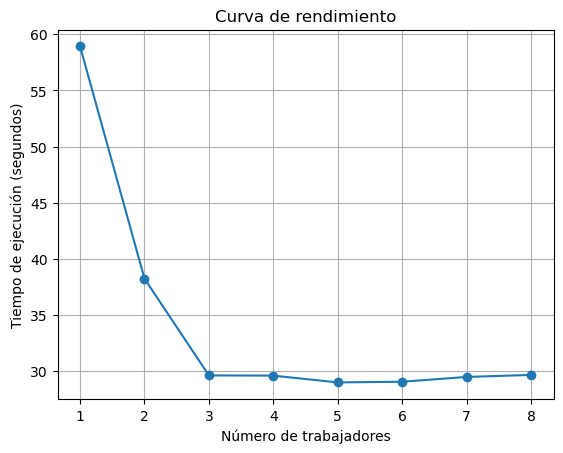

In [16]:
plt.plot(num_workers, tiempos_ejecucion, marker='o')
plt.title('Curva de rendimiento')
plt.xlabel('Número de trabajadores')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.grid(True)
plt.show()

In [17]:
num_workers = list(range(1, 9))
tiempos_ejecucion_cv = []

for i in num_workers:
    print(f"Test with {i} core/s")
    sc.stop()
    sc = SparkContext(f"local[{i}]", "Paralelize")
    total_time, _ = test_cv(path, print_it=False)
    tiempos_ejecucion_cv.append(total_time)

Test with 1 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/14 11:45:02 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 92.70885442721361 %
Time for block 0: 55.8130989074707
Block 1


24/02/14 11:46:04 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 93.4349883572448 %
Time for block 1: 55.15031385421753
Block 2


24/02/14 11:47:06 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 92.52141007767376 %
Time for block 2: 54.29808044433594
Block 3


24/02/14 11:48:07 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 93.5630689206762 %
Time for block 3: 56.044060468673706
Block 4


24/02/14 11:49:10 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 93.33916083916084 %
Time for block 4: 54.10608720779419
Block 5


24/02/14 11:50:10 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 93.38310569552299 %
Time for block 5: 54.09816813468933
Block 6


24/02/14 11:51:11 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 92.53843269591302 %
Time for block 6: 53.89701247215271
Block 7


24/02/14 11:52:11 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 93.47858790492428 %
Time for block 7: 53.86877512931824
Block 8


Accuracy of the model: 93.47545219638243 %
Time for block 8: 53.40325665473938
Block 9


24/02/14 11:54:12 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 93.02774366557229 %
Time for block 9: 54.220778942108154
Average accuracy: 93.14708047802841 %
Average time: 544.8996322154999 s
Test with 2 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/14 11:55:19 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 92.47671602287198 %
Time for block 0: 36.03334665298462
Block 1


24/02/14 11:55:59 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 92.21664097080618 %
Time for block 1: 37.13807225227356
Block 2


24/02/14 11:56:40 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 93.51228184390415 %
Time for block 2: 36.51334547996521
Block 3


24/02/14 11:57:21 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 91.17443527260146 %
Time for block 3: 37.66462421417236
Block 4


24/02/14 11:58:03 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 92.95848791737691 %
Time for block 4: 38.22997164726257
Block 5


24/02/14 11:58:46 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.2312982595526 %
Time for block 5: 36.898940086364746
Block 6


24/02/14 11:59:27 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 94.09300799878882 %
Time for block 6: 37.13609266281128
Block 7


24/02/14 12:00:08 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 91.5485943375084 %
Time for block 7: 35.43940782546997
Block 8


24/02/14 12:00:47 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 91.84862442424996 %
Time for block 8: 36.56304121017456
Block 9


24/02/14 12:01:28 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 92.27139968546395 %
Time for block 9: 36.77999234199524
Average accuracy: 92.43314867331243 %
Average time: 368.3968343734741 s
Test with 3 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/14 12:02:14 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 93.4588329536636 %
Time for block 0: 29.414979457855225
Block 1


24/02/14 12:02:47 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 92.55263355061062 %
Time for block 1: 29.20289945602417
Block 2


24/02/14 12:03:19 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 92.48635931321019 %
Time for block 2: 27.737815856933594
Block 3


24/02/14 12:03:49 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 92.51147475553782 %
Time for block 3: 27.850160598754883
Block 4


24/02/14 12:04:20 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 93.9259925542813 %
Time for block 4: 28.629513025283813
Block 5


24/02/14 12:04:51 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.69384692346173 %
Time for block 5: 29.99960732460022
Block 6


24/02/14 12:05:24 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 92.93735962066384 %
Time for block 6: 28.90679168701172
Block 7


24/02/14 12:05:56 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 93.83428228948156 %
Time for block 7: 29.065760850906372
Block 8


24/02/14 12:06:28 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 93.33450315852802 %
Time for block 8: 29.37747097015381
Block 9


Accuracy of the model: 92.19971128478272 %
Time for block 9: 28.670304775238037
Average accuracy: 92.99349964042213 %
Average time: 288.85530400276184 s
Test with 4 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


Accuracy of the model: 93.76569878428614 %
Time for block 0: 27.6374568939209
Block 1


24/02/14 12:08:07 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 92.85321605277625 %
Time for block 1: 26.44411873817444
Block 2


24/02/14 12:08:35 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 91.7676087931808 %
Time for block 2: 25.750484228134155
Block 3


24/02/14 12:09:03 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 93.6034275405893 %
Time for block 3: 26.381654977798462
Block 4


24/02/14 12:09:32 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 94.16784487982225 %
Time for block 4: 25.765751600265503
Block 5


24/02/14 12:09:59 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.44430093639005 %
Time for block 5: 25.290988206863403
Block 6


24/02/14 12:10:27 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 93.92155880585054 %
Time for block 6: 25.59142565727234
Block 7


24/02/14 12:10:55 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 93.08392567651826 %
Time for block 7: 25.367446660995483
Block 8


24/02/14 12:11:22 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 93.12599840255591 %
Time for block 8: 25.00088095664978
Block 9


24/02/14 12:11:50 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 93.81971661139583 %
Time for block 9: 25.854297399520874
Average accuracy: 93.25532964833653 %
Average time: 259.08450531959534 s
Test with 5 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/14 12:12:23 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 92.591762537975 %
Time for block 0: 25.342931509017944
Block 1


24/02/14 12:12:51 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 93.26323695080735 %
Time for block 1: 26.120747327804565
Block 2


Accuracy of the model: 92.66310426245806 %
Time for block 2: 27.612806797027588
Block 3


24/02/14 12:13:49 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 93.18416349953436 %
Time for block 3: 26.19745707511902
Block 4


24/02/14 12:14:18 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 92.63817520992606 %
Time for block 4: 25.404136896133423
Block 5


24/02/14 12:14:45 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.56235376113905 %
Time for block 5: 25.62887167930603
Block 6


24/02/14 12:15:13 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 92.29598582940399 %
Time for block 6: 26.300349712371826
Block 7


24/02/14 12:15:42 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 92.06467847621894 %
Time for block 7: 26.038800716400146
Block 8


24/02/14 12:16:10 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 91.81995401379586 %
Time for block 8: 25.939786911010742
Block 9


24/02/14 12:16:38 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 92.5704568756408 %
Time for block 9: 26.238209009170532
Average accuracy: 92.56538714168997 %
Average time: 260.8240976333618 s
Test with 6 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/14 12:17:13 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 94.28664625884478 %
Time for block 0: 26.593880891799927
Block 1


24/02/14 12:17:41 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 92.39741252279028 %
Time for block 1: 26.182246685028076
Block 2


24/02/14 12:18:10 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 92.81667290652689 %
Time for block 2: 25.398507118225098
Block 3


24/02/14 12:18:37 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 92.53018674533136 %
Time for block 3: 25.329251766204834
Block 4


24/02/14 12:19:05 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 93.33116134529598 %
Time for block 4: 25.427547216415405
Block 5


24/02/14 12:19:33 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 93.09551783616229 %
Time for block 5: 26.715026140213013
Block 6


24/02/14 12:20:02 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 92.33927498497897 %
Time for block 6: 25.65082836151123
Block 7


24/02/14 12:20:30 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 94.01310339634009 %
Time for block 7: 26.064577102661133
Block 8


24/02/14 12:20:58 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 92.79692722103057 %
Time for block 8: 27.32903027534485
Block 9


Accuracy of the model: 92.028931474163 %
Time for block 9: 25.501384496688843
Average accuracy: 92.96358346914641 %
Average time: 260.1922800540924 s
Test with 7 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/14 12:22:01 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 93.06278790306429 %
Time for block 0: 26.780747175216675
Block 1


24/02/14 12:22:30 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 93.14554460399259 %
Time for block 1: 25.60099697113037
Block 2


24/02/14 12:22:58 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 93.20699052428932 %
Time for block 2: 25.836844444274902
Block 3


24/02/14 12:23:26 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 92.77999293393226 %
Time for block 3: 25.450563669204712
Block 4


24/02/14 12:23:54 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 92.56846151925909 %
Time for block 4: 26.080379009246826
Block 5


24/02/14 12:24:22 WARN BlockManager: Task 513 already completed, not releasing lock for rdd_287_0


Accuracy of the model: 92.98430105911515 %
Time for block 5: 26.95336151123047
Block 6


24/02/14 12:24:51 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 92.47106670348705 %
Time for block 6: 25.466716289520264
Block 7


24/02/14 12:25:19 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 92.53965878479497 %
Time for block 7: 25.623349905014038
Block 8


24/02/14 12:25:47 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 92.76613746080724 %
Time for block 8: 27.0003399848938
Block 9


24/02/14 12:26:16 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 92.36256609797466 %
Time for block 9: 25.817997217178345
Average accuracy: 92.78875075907166 %
Average time: 260.6112961769104 s
Test with 8 core/s


Means: [1.27838919e+03 2.13364895e+04 6.93013712e+03 6.25819129e+04
 1.22276971e+08 1.57460545e+07 9.11132215e+00 1.89416481e+00
 1.24196646e+02 2.12980313e+09 2.25738831e+09]

Std: [1.60563017e+03 2.41267530e+04 1.63668384e+04 1.34535232e+05
 2.34005376e+08 4.41865109e+07 5.28106132e+00 2.10223611e+00
 9.03451248e+01 7.14764695e+08 1.30262025e+09]

Block 0


24/02/14 12:26:50 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_7_0


Accuracy of the model: 92.5590561001771 %
Time for block 0: 25.905736207962036
Block 1


24/02/14 12:27:18 WARN BlockManager: Task 125 already completed, not releasing lock for rdd_63_0


Accuracy of the model: 92.511167120006 %
Time for block 1: 25.786702632904053
Block 2


24/02/14 12:27:46 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_119_0


Accuracy of the model: 92.34195905700986 %
Time for block 2: 26.884479761123657
Block 3


24/02/14 12:28:16 WARN BlockManager: Task 319 already completed, not releasing lock for rdd_175_0


Accuracy of the model: 92.82319273360707 %
Time for block 3: 26.798258543014526
Block 4


24/02/14 12:28:45 WARN BlockManager: Task 416 already completed, not releasing lock for rdd_231_0


Accuracy of the model: 92.45624473201448 %
Time for block 4: 25.798245191574097
Block 5


Accuracy of the model: 92.41384473336161 %
Time for block 5: 25.28495693206787
Block 6


24/02/14 12:29:41 WARN BlockManager: Task 610 already completed, not releasing lock for rdd_343_0


Accuracy of the model: 91.34203422571139 %
Time for block 6: 26.510786056518555
Block 7


24/02/14 12:30:09 WARN BlockManager: Task 707 already completed, not releasing lock for rdd_399_0


Accuracy of the model: 92.85714285714286 %
Time for block 7: 26.682584047317505
Block 8


24/02/14 12:30:39 WARN BlockManager: Task 804 already completed, not releasing lock for rdd_455_0


Accuracy of the model: 92.4337071322847 %
Time for block 8: 27.481422901153564
Block 9


24/02/14 12:31:08 WARN BlockManager: Task 901 already completed, not releasing lock for rdd_511_0


Accuracy of the model: 92.38861540768136 %
Time for block 9: 27.589547395706177
Average accuracy: 92.41269640989965 %
Average time: 264.72271966934204 s


In [21]:
acceleration = []
for i in range(0, 8):
    acceleration.append(tiempos_ejecucion[0]/tiempos_ejecucion[i]) 

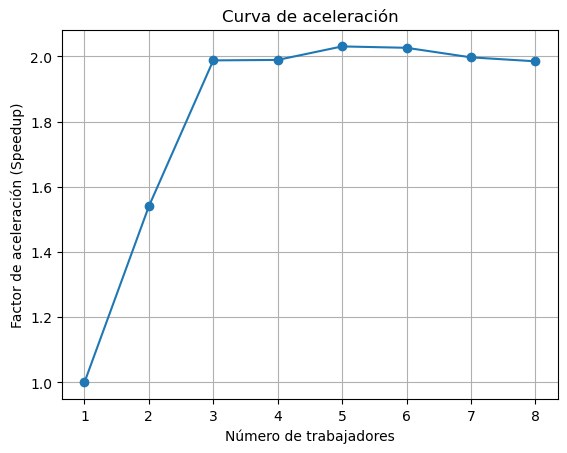

In [22]:
plt.plot(num_workers, acceleration, marker='o')
plt.title('Curva de aceleración')
plt.xlabel('Número de trabajadores')
plt.ylabel('Factor de aceleración (Speedup)')
plt.grid(True)
plt.show()